In [1]:
import numpy as np
import pfnet as pf
from scipy.sparse import triu,bmat,coo_matrix,eye,spdiags
import matplotlib.pyplot as plt
from scikits.sparse.cholmod import cholesky

%matplotlib inline  

In [3]:
from multiprocess import Pool,cpu_count

In [4]:
from cvxpy import *
import mosek
import gurobi
import pickle
import dill
import time

In [5]:
# sys.setrecursionlimit(10000)

In [6]:
# dill.load_session(filename='pickle/test_sess.pkl')

In [7]:
results=dill.load( open( "pickle/Stoch_Hybrid_ieee300_20iter_3pwl_gurobi_cluster.p", "rb" ) )
# scenarios_bus=dill.load( open( "pickle/scenarios_bus.p", "rb" ) )
# Constraints=list(dill.load( open( "pickle/Constraints.p", "rb" )))
# Objective=dill.load( open( "pickle/Objective.p", "rb" ) )
# on_off_cost=pickle.load( open( "pickle/on_off_cost.p", "rb" ) )
# variables=dill.load( open( "pickle/variables.p", "rb" ) )
# constants=dill.load( open( "pickle/constants.p", "rb" ) )

In [8]:
# results['time_SS']

In [9]:
# Constraints=list(results['Constraint'])
# Objective=results['Objective']
# variables=results['variables']
# constants=results['constants']

In [10]:
for res in results.keys():
    exec (res + "= results[res]")

In [11]:
for var in variables.keys():
    exec (var + "= variables[var]")
for cons in constants.keys():
    exec (cons + "= constants[cons]")
    


In [12]:
p=Variable(p.size[0],p.size[1])
w=Variable(w.size[0],w.size[1])
s=Variable(s.size[0],s.size[1])
load=Variable(load.size[0],load.size[1])
on_off_param=Parameter(num_p,n_h)
r_parameter=Parameter(s.size[0],s.size[1])


if PWL:
    gk=Variable(gk.size[0],gk.size[1])

on_off_value=np.zeros((num_p,n_h))
on_off_init=np.zeros(num_p)


In [13]:
r=np.mean(scenarios_bus,2)

In [14]:
def eval_obj (on_off,on_off_cost=on_off_cost,n_h=24):
    obj_eval=0
    for i in range(1,n_h):
        obj_eval = obj_eval + np.sum(on_off_cost*np.maximum(on_off[:,i] - on_off[:,i-1],0))
    obj_eval = obj_eval + np.sum((on_off_cost)*np.maximum(on_off[:,0].T - on_off_init,0).T)

#     for i in range (n_h):
#         if PWL:
#             for j in range(pwl_points):
#                 for k in range(num_p):
#                     obj_eval=obj_eval + gk[k+(num_p*j),i]*pwl_cost[k,j]
#         else:
#             obj_eval=obj_eval + 0.5*p[:,i].T*H0*p[:,i]
#             obj_eval=obj_eval + g0*p[:,i]# check 

#         obj_eval=obj_eval + Load_Penalty*np.linalg.norm(load[:,i]-b[:,i],1)
        
    return obj_eval


In [15]:
PWL=False

In [16]:
#         Constraints.append([gk[num_p*j:num_p*(j+1),i]<=p_max/(pwl_points) for j in range(pwl_points)][0])
#         Constraints.append([gk[num_p*j:num_p*(j+1),i]>=0 for j in range(pwl_points)][0])

In [17]:
# init constraints second stage

Constraints=[]
for i in range (n_h):
    Constraints.append(p[:,i]<=mul_elemwise(p_max[:],on_off_param[:,i]))
for i in range (n_h):
    Constraints.append(p[:,i]>=mul_elemwise(p_min[:],on_off_param[:,i]))
for i in range (n_h):
    Constraints.append(s[:,i]<=r_parameter[:,i])

for i in range (n_h):
    if PWL:
        for j in range (pwl_points):
            Constraints.append(gk[num_p*j:num_p*(j+1),i]<=p_max/(pwl_points))
            Constraints.append(gk[num_p*j:num_p*(j+1),i]>=0)
    
        Constraints.append( p[:,i]== np.sum ([gk[num_p*j:num_p*(j+1),i] for j in range(pwl_points)]) )
       
    Constraints.append(G*p[:,i]+R*s[:,i]-A*w[:,i]==Dm*load[:,i])
    Constraints.append(w[:,i]<=w_max)
    Constraints.append(w[:,i]>=w_min)
    Constraints.append(J*w[:,i]<=z_max)
    Constraints.append(J*w[:,i]>=z_min)
    #Changed here
    Constraints.append(s[:,i]>=0)
    Constraints.append(load[:,i]>=0)
    Constraints.append(load[:,i]<=b[:,i])
for i in range(1,n_h):
    Constraints.append(p[:,i]-p[:,i-1]<=rampup[:])
    Constraints.append(p[:,i]-p[:,i-1]>=-rampdown[:])   
    

# init objective secon stage

Objective=0
for i in range (n_h):
    if PWL:
        for j in range(pwl_points):
            Objective=Objective + sum_entries(mul_elemwise(pwl_cost[:,j],gk[num_p*j:num_p*(j+1),i]))
#             for k in range(num_p):
#                 Objective=Objective + gk[k+(num_p*j),i]*pwl_cost[k,j]
    else:
        Objective=Objective + quad_form(p[:,i],H0*0.5)
        Objective=Objective + g0*p[:,i]# check 
        
    Objective=Objective + Load_Penalty*norm(load[:,i]-b[:,i],1)
# Objective=Objective/10
prob = []
prob = Problem(Minimize(Objective), Constraints)



In [54]:
def plot_demand(p,load,s,r,b,n_h):
    colors=['#d7191c','#fdae61','#abdda4','#2b83ba'] #['#ef8a62','#f7f7f7','#67a9cf','#008837']
    plt.figure(figsize=(10,10))
    plt.fill_between(range(n_h),np.zeros(n_h),np.squeeze(np.asarray(sum(p))),color=colors[3])
    plt.fill_between(range(n_h),np.squeeze(np.asarray(sum(p))),
                     np.squeeze(np.asarray(sum(p)+sum(s))),
                     color=colors[1])

    plt.fill_between(range(n_h),np.squeeze(np.asarray(sum(b))),
                     np.squeeze(np.asarray(sum(load))),
                     color=colors[0])
    plt.plot(range(n_h),np.squeeze(np.asarray(sum(b))),color='k',linewidth=3.0)
    plt.fill_between(range(n_h),np.zeros(n_h),-np.squeeze(np.asarray(np.abs(-sum(s)+sum(r)))),color=colors[2])
    plt.legend(['Demand','Generation','Renewable','Demand not served','Curtailed Renewable '],loc='best')
    plt.show()

In [29]:
def eval_on_off(on_off_value,r,j,k,duals=False,n_h=n_h,num_p=num_p):     
    on_off_param.value=on_off_value[k]
    r_parameter.value=r[:,:,j]
    Q=prob.solve(solver=ECOS,verbose=False,)
    if not duals:
        return Q,p.value,load.value,s.value
    


In [20]:
on_off_array1=[]
on_off_array1= pickle.load(open( "pickle/Stoch_Hybrid_ieee300_gurobi_test_3pwl_cluster.p", "rb" ) )

In [21]:
# results1= pickle.load(open( "pickle/Stoch_Hybrid_ieee300_100iter.p", "rb" ) )

In [22]:
# results1['on_off_array'][0]

In [23]:
# kk=4
# np.sum(on_off_array[kk]!=results1['on_off_array'][kk])

In [26]:
pool=Pool(4,args=(k,))

NameError: name 'k' is not defined

In [36]:
len(on_off_array)

20

In [37]:
range(0,len(on_off_array),5)+[-1]

[0, 5, 10, 15, -1]

In [26]:
# partial_func=partial(eval_on_off,on_off_value=on_off_array[0])
# partial_func(r=scenarios_bus[:,:,n_samples:n_samples+10],j=1)

In [30]:
Q_dict={}
p_dict={}
load_dict={}
s_dict={}
for k in range(2):
    Q_value=[]
    p_value=[]
    load_value=[]
    s_value=[]
    pool=Pool(4,initargs=(k,))
    ocost=eval_obj(on_off=on_off_array[k])#results['on_off_array'][0]
    st=time.time()
    print "start"
    st=time.time()
    res = list(zip(*pool.map(lambda i: eval_on_off(on_off_value=on_off_array,
                                                   r=scenarios_bus[:,:,n_samples:n_samples+10],j=i,k=k),
                                                   range(10),
                                                    chunksize=1)
                  ))
    print time.time()-st
    Q_dict[str(k)]=list(res[0])+ocost
    p_dict[str(k)]=np.mean(res[1],0)
    load_dict[str(k)]=np.mean(res[2],0)
    s_dict[str(k)]=np.mean(res[3],0)
    pool.close()
    pool.join()

start
13.9100089073
start
14.1202001572


In [75]:
res[1][0]

matrix([[  1.23701515e-11,   8.24822808e-12,   1.83182213e-11, ...,
           9.36931840e-11,   3.68638374e-12,  -1.00506790e-12],
        [  1.15712957e-11,   6.49531659e-12,   1.89065850e-11, ...,
           1.05128376e-10,   8.98406237e-13,  -4.82317968e-12],
        [  1.20616679e-11,   8.01493148e-12,   1.79055641e-11, ...,
           9.26179043e-11,   3.53826831e-12,  -1.06426646e-12],
        ..., 
        [  1.20571840e-11,   8.01241333e-12,   1.78983550e-11, ...,
           9.28893861e-11,   3.58628200e-12,  -1.05739767e-12],
        [  1.20573921e-11,   8.01250837e-12,   1.78986700e-11, ...,
           9.28902842e-11,   3.58693199e-12,  -1.05751062e-12],
        [  1.20575639e-11,   8.01261450e-12,   1.78990335e-11, ...,
           1.00000000e+00,   3.57541262e-12,  -1.05805522e-12]])

In [40]:
print np.mean(Q_dict[str(1)])

5374.8168167


In [49]:
Q_value

array([ 5108.3075405 ,  5108.94410946,  4863.3966163 ,  4925.21711634,
        4864.48162503,  4879.82526288,  4822.68470331,  5714.11640054,
        4739.08398276,  5028.74249715])

In [29]:
print np.mean(Q_value),np.max(Q_value),np.min(Q_value) # Gurobi 20 iter

5120.88810097 5314.7431914 4991.65633816


In [31]:
print np.mean(Q_value),np.max(Q_value) ,np.min(Q_value) # Ecos 0 iter

5004.49456299 6703.69091389 4639.31747618


In [33]:
print np.mean(Q_value),np.max(Q_value) ,np.min(Q_value) # GUROBI Cluster 0 iter

4998.24101194 5706.87742705 4731.84500927


In [31]:
print np.mean(Q_value),np.max(Q_value),np.min(Q_value) # Gurobi 5 iter 3pwl

4998.24101194 5706.87742705 4731.84500927


In [63]:
print np.mean(Q_value),np.max(Q_value),np.min(Q_value) # No renewables 

4257.66597705 4966.30239216 3991.26997438


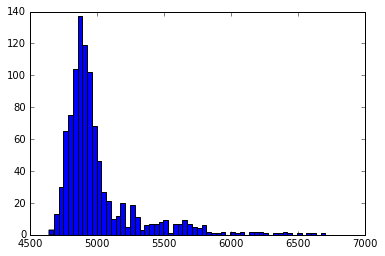

In [32]:
plt.hist(Q_value,bins='auto')
plt.show()

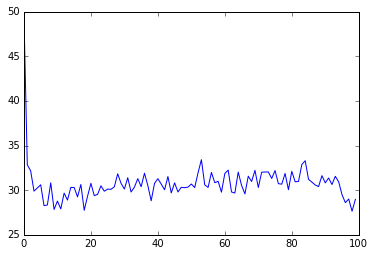

In [45]:
plt.plot(time_eval)

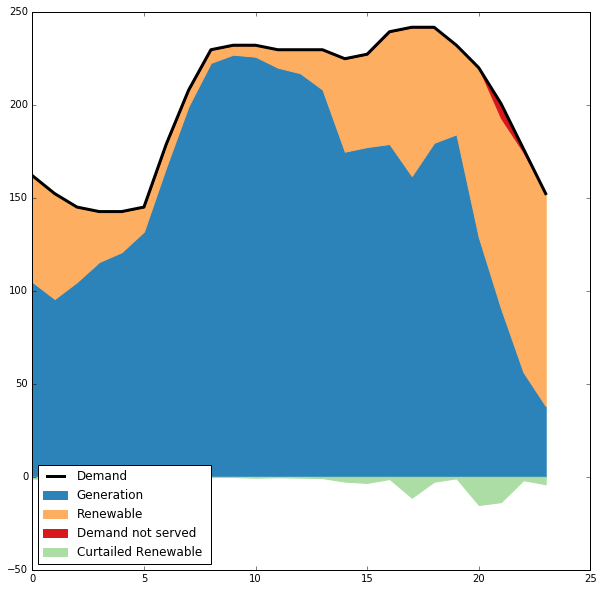

In [76]:
plot_demand(p=np.mean(res[1],0),load=np.mean(res[2],0),s=np.mean(res[3],0),r=np.mean(scenarios_bus,2),b=b,n_h=n_h)

Nuclear
IGCC
Coal
CCGT
OCGT


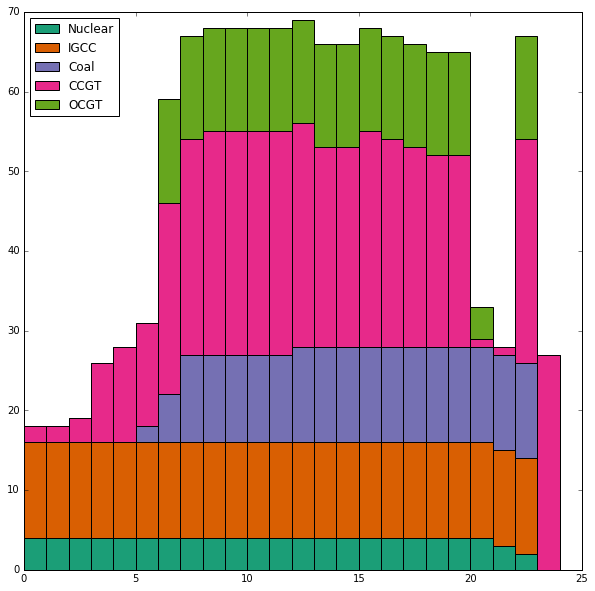

In [27]:
# gen_tech=['CCGT', 'CCGT', 'CCGT', 'IGCC', 'Nuclear'], 

sorted_name_techno=['Nuclear','IGCC','Coal','CCGT','OCGT']
N = n_h
ind = np.arange(N)  # the x locations for the groups
width = 1
aux=[]
aux.append(np.zeros(N).T)
cumsum_aux=np.zeros(N)
fig, ax = plt.subplots(figsize=(10,10))
# rects = ax.bar(ind, strategy1_optMean, width, color=color[0])
colors=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
for idx,name in enumerate(sorted_name_techno):
    print name
    aux.append(np.array([np.sum(np.ceil(o_test[j,i]) for j in range (num_p) if gen_tech[j]==name) for i in range(n_h)]))
    cumsum_aux=np.cumsum(aux,0)
#     print aux[-1]
    rects = ax.bar(ind, aux[idx+1], width, color=colors[idx],bottom=cumsum_aux[idx])
plt.legend(sorted_name_techno,loc='best')  
plt.show()


Nuclear
IGCC
Coal
CCGT
OCGT


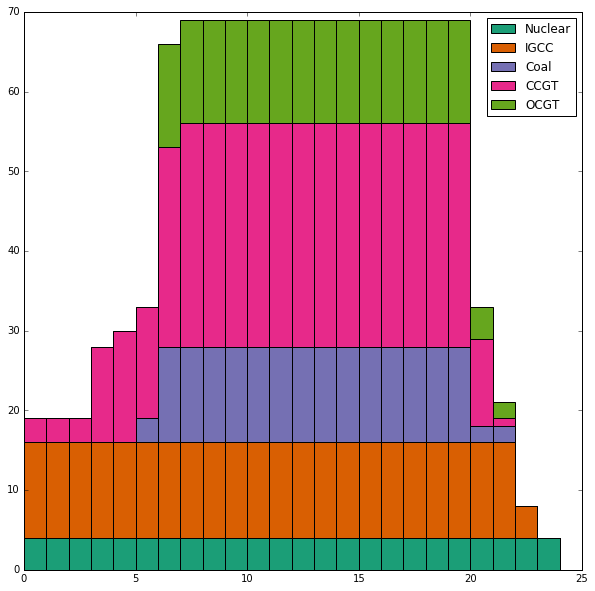

In [32]:
sorted_name_techno=['Nuclear','IGCC','Coal','CCGT','OCGT']
N = n_h
ind = np.arange(N)  # the x locations for the groups
width = 1
aux=[]
aux.append(np.zeros(N).T)
cumsum_aux=np.zeros(N)
fig, ax = plt.subplots(figsize=(10,10))
# rects = ax.bar(ind, strategy1_optMean, width, color=color[0])
colors=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
for idx,name in enumerate(sorted_name_techno):
    print name
    aux.append(np.array([np.sum(np.ceil(o_test[j,i]) for j in range (num_p) if gen_tech[j]==name) for i in range(n_h)]))
    cumsum_aux=np.cumsum(aux,0)
#     print aux[-1]
    rects = ax.bar(ind, aux[idx+1], width, color=colors[idx],bottom=cumsum_aux[idx])
plt.legend(sorted_name_techno,loc='best')  
plt.show()


In [91]:
try:
    1/0
except:
    print "paila"
else:
    print "1"

paila
